In [8]:
import pandas as pd
import requests
from bs4 import BeautifulSoup, Comment
from io import StringIO
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [2]:
coaches_df = pd.read_html('https://www.pro-football-reference.com/coaches/', index_col=0)[0]

In [3]:
def wasHOF(coach):
    if "+" in coach:
        return True
    else:
        return False
coaches_df["HOF"] = coaches_df["Coach"].apply(wasHOF)
coaches_df["Coach"] = coaches_df.Coach.str.split("+", n=1).str[0]


In [4]:
fucked_up_names = {
    "John Fox": "FoxxJo0",
    "Buddy Parker": "ParkRa0",
    "Jack Del Rio": "DelRJa0",
    "Buck Shaw": "ShawLa0",
    "Norm Van Brocklin": "VanBNo0",
    "Jim Lee Howell": "HoweJi0",
    "Bill O'Brien": "OBriBi0",
    "Kevin O'Connell": "OConKe0",
    "Pop Ivy": "IvyxPo0",
    "Red Hickey": "HickHo0",
    "Red Strader": "StraNo0",
    "Bo McMillin": "McMiAl0",
    "Lone Star Dietz": "DietLo0", 
    "Buster Ramsey": "RamsGa0",
    "Forrest Douds": "DoudJa0",
    "Ray Willsey": "WilsRa0",
    "Bill Conkright": "ConkRe0",
    "Fred O'Connor": "OConFr0",
    
}

In [5]:
def fixJimMora(row):
    if row["Coach"] == "Jim Mora" and row["Yrs"] == 4:
        return "Jim Mora1"
    else:
        return row["Coach"]
coaches_df["Coach"] = coaches_df.apply(fixJimMora, axis=1)


In [6]:
def getCoachCode(row, fucked_up_names):
    coach = row["Coach"]
    if coach in fucked_up_names.keys():
        return fucked_up_names[coach]
    elif coach == "Jim Mora1":
        return "MoraJi1"
    return coach[coach.find(" ") + 1:coach.find(" ") + 5]+ coach[:2] + "0"
coaches_df["Coach_Code"] = coaches_df.apply(lambda row: getCoachCode(row, fucked_up_names), axis=1)

In [7]:
def getCoachUrl(coach_code):
    return f"https://www.pro-football-reference.com/coaches/{coach_code}.htm"
coaches_df["Coach_URL"] = coaches_df["Coach_Code"].apply(getCoachUrl)
coaches_df

Coach  Yrs  From    To    G    W    L   T   W-L%  G > .500  ...  \
Rk                                                                        ...   
1         Don Shula   33  1963  1995  490  328  156   6  0.677       172  ...   
2      George Halas   40  1920  1967  497  318  148  31  0.682       170  ...   
3    Bill Belichick   29  1991  2023  467  302  165   0  0.647       137  ...   
4         Andy Reid   26  1999  2024  420  273  146   1  0.651       127  ...   
5        Tom Landry   29  1960  1988  418  250  162   6  0.607        88  ...   
..              ...  ...   ...   ...  ...  ...  ...  ..    ...       ...  ...   
527   Johnny Murphy    1  1924  1924    4    0    4   0  0.000        -4  ...   
528       Al Nesser    1  1926  1926    2    0    1   1  0.000        -1  ...   
529        Tam Rose    1  1921  1921    1    0    1   0  0.000        -1  ...   
530     Lenny Sachs    1  1926  1926    4    0    4   0  0.000        -4  ...   
531      Giff Smith    1  2023  2023    3    0    3   0  0.000        -3  ...   

     L plyf  W-L%.1  AvRk  BstRk  Chmp  SBwl  Conf    HOF  Coach_Code  \
Rk                                                                      
1      17.0   0.528   1.8      1   2.0   2.0   6.0   True     ShulDo0   
2       3.0   0.667   2.7      1   6.0   0.0   0.0   True     HalaGe0   
3      13.0   0.705   1.8      1   6.0   6.0   9.0  False     BeliBi0   
4      17.0   0.622   1.8      1   3.0   3.0   6.0  False     ReidAn0   
5      16.0   0.556   2.4      1   2.0   2.0   5.0   True     LandTo0   
..      ...     ...   ...    ...   ...   ...   ...    ...         ...   
527     0.0     NaN  16.0     16   0.0   0.0   0.0  False     MurpJo0   
528     0.0     NaN  16.0     16   0.0   0.0   0.0  False     NessAl0   
529     0.0     NaN  18.0     18   0.0   0.0   0.0  False     RoseTa0   
530     0.0     NaN  21.0     21   0.0   0.0   0.0  False     SachLe0   
531     NaN     NaN   4.0      4   NaN   NaN   NaN  False     SmitGi0   

                                             Coach_URL  
Rk                                                      
1    https://www.pro-football-reference.com/coaches...  
2    https://www.pro-football-reference.com/coaches...  
3    https://www.pro-football-reference.com/coaches...  
4    https://www.pro-football-reference.com/coaches...  
5    https://www.pro-football-reference.com/coaches...  
..                                                 ...  
527  https://www.pro-football-reference.com/coaches...  
528  https://www.pro-football-reference.com/coaches...  
529  https://www.pro-football-reference.com/coaches...  
530  https://www.pro-football-reference.com/coaches...  
531  https://www.pro-football-reference.com/coaches...  

[531 rows x 23 columns]

In [8]:
def getAdditionalTables(coach_code, verbose=False):

    url = f"https://www.pro-football-reference.com/coaches/{coach_code}.htm"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    coach_results_df = None
    team_ranks_df = None
    coaching_history_df = None
    worked_for_df = None
    employed_df = None

    coach_results_html = soup.find('div', {'id': 'all_coaching_results'})
    try:
        commented_section = coach_results_html.find(string=lambda string: isinstance(string, Comment))
        if commented_section:
            soup_comment = BeautifulSoup(commented_section, 'html.parser')
            coaching_table = soup_comment.find('table', {'id': 'coaching_results'})
            if coaching_table:
                coach_results_df = pd.read_html(StringIO(str(coaching_table)))[0]
        else:
            coaching_table = coach_results_html.find('table', {'id': 'coaching_results'})
            if coaching_table:
                coach_results_df = pd.read_html(StringIO(str(coaching_table)))[0]
    except:
        if verbose:
            print(coach_code, "coach results")


    # Team Ranks ------------------------------------------------------------

    team_ranks_html = soup.find('div', {'id': 'all_coaching_ranks'})
    try:
        commented_section = team_ranks_html.find(string=lambda string: isinstance(string, Comment))
        if commented_section:
            soup_comment = BeautifulSoup(commented_section, 'html.parser')
            coaching_table = soup_comment.find('table', {'id': 'coaching_ranks'})
            if coaching_table:
                team_ranks_df = pd.read_html(StringIO(str(coaching_table)))[0]
        else:
            coaching_table = team_ranks_html.find('table', {'id': 'coaching_ranks'})
            if coaching_table:
                team_ranks_df = pd.read_html(StringIO(str(coaching_table)))[0]
    except:
        if verbose:
            print(coach_code, "team ranks")


    # Coaching History ------------------------------------------------------------

    coach_history_html = soup.find('div', {'id': 'all_coaching_history'})
    try:
        commented_section = coach_history_html.find(string=lambda string: isinstance(string, Comment))
        if commented_section:
            soup_comment = BeautifulSoup(commented_section, 'html.parser')
            coaching_table = soup_comment.find('table', {'id': 'coaching_history'})
            if coaching_table:
                coaching_history_df = pd.read_html(StringIO(str(coaching_table)))[0]
        else:
            coaching_table = coach_history_html.find('table', {'id': 'coaching_history'})
            if coaching_table:
                coaching_history_df = pd.read_html(StringIO(str(coaching_table)))[0]
    except:
        if verbose: 
            print(coach_code, "coaching history")

    # Worked For ------------------------------------------------------------

    worked_for_history_html = soup.find('div', {'id': 'all_worked_for'})
    try:
        commented_section = worked_for_history_html.find(string=lambda string: isinstance(string, Comment))
        if commented_section:
            soup_comment = BeautifulSoup(commented_section, 'html.parser')
            coaching_table = soup_comment.find('table', {'id': 'worked_for'})
            if coaching_table:
                worked_for_df = pd.read_html(StringIO(str(coaching_table)))[0]
        else:
            coaching_table = coach_results_html.find('table', {'id': 'worked_for'})
            if coaching_table:
                worked_for_df = pd.read_html(StringIO(str(coaching_table)))[0]
    except:
        if verbose:
            print(coach_code, "worked for")

    # Employed ------------------------------------------------------------

    employed_history_html = soup.find('div', {'id': 'all_employed'})
    try:
        commented_section = employed_history_html.find(string=lambda string: isinstance(string, Comment))
        if commented_section:
            soup_comment = BeautifulSoup(commented_section, 'html.parser')
            coaching_table = soup_comment.find('table', {'id': 'employed'})
            if coaching_table:
                employed_df = pd.read_html(StringIO(str(coaching_table)))[0]
        else:
            coaching_table = coach_results_html.find('table', {'id': 'employed'})
            if coaching_table:
                employed_df = pd.read_html(StringIO(str(coaching_table)))[0]
    except:
        if verbose:
            print(coach_code, "employed")

    return coach_results_df, team_ranks_df, coaching_history_df, worked_for_df, employed_df


In [9]:
additional_coach_tables = {}

for coach in tqdm(coaches_df["Coach_Code"], desc="Fetching coach data"):
    additional_coach_tables[coach] = getAdditionalTables(coach)
    time.sleep(2)

Fetching coach data: 100%|██████████| 531/531 [19:19<00:00,  2.18s/it]


In [41]:
coaching_history_combined = pd.concat(
    [tables[2] for tables in additional_coach_tables.values()],
    keys=additional_coach_tables.keys()
)
coaching_history_combined.reset_index(inplace=True)
coaching_history_combined.drop(columns=["level_1"], inplace=True)
coaching_history_combined.rename(columns={"level_0": "Coach_Code"}, inplace=True)

In [ ]:
coaching_history_combined = coaching_history_combined.merge(coaches_df[["Coach", "Coach_Code"]], how="right", left_on="Coach_Code", right_on="Coach_Code")
coaching_history_combined.set_index(['Coach', coaching_history_combined.index], inplace=True)
coaching_history_combined

In [5]:
coach_codes = list(coaching_history_combined.index.get_level_values(0).unique())
adjacency_matrix = pd.DataFrame(0, index=coach_codes, columns=coach_codes)

for year in coaching_history_combined.Year.unique():
    year_data = coaching_history_combined[coaching_history_combined.Year == year]
    
    for employer in year_data.Employer.unique():
        coaches = year_data[year_data.Employer == employer].index.get_level_values(0).unique()
        
        for i in range(len(coaches)):
            for j in range(i+1, len(coaches)):
                adjacency_matrix.loc[coaches[i], coaches[j]] = 1
                adjacency_matrix.loc[coaches[j], coaches[i]] = 1

np.fill_diagonal(adjacency_matrix.values, 0)


In [12]:
with open('additional_coach_tables.pkl', 'wb') as f:
    pickle.dump(additional_coach_tables, f)
coaching_history_combined.to_pickle('coaching_history.pkl')
coaches_df.to_pickle('coaches_df.pkl')
adjacency_matrix.to_pickle('adjacency_matrix.pkl')

In [13]:
additional_coach_tables = pickle.load(open('additional_coach_tables.pkl', 'rb'))
coaching_history_combined = pd.read_pickle('coaching_history.pkl')
coaches_df = pd.read_pickle('coaches_df.pkl')
adjacency_matrix = pd.read_pickle('adjacency_matrix.pkl')


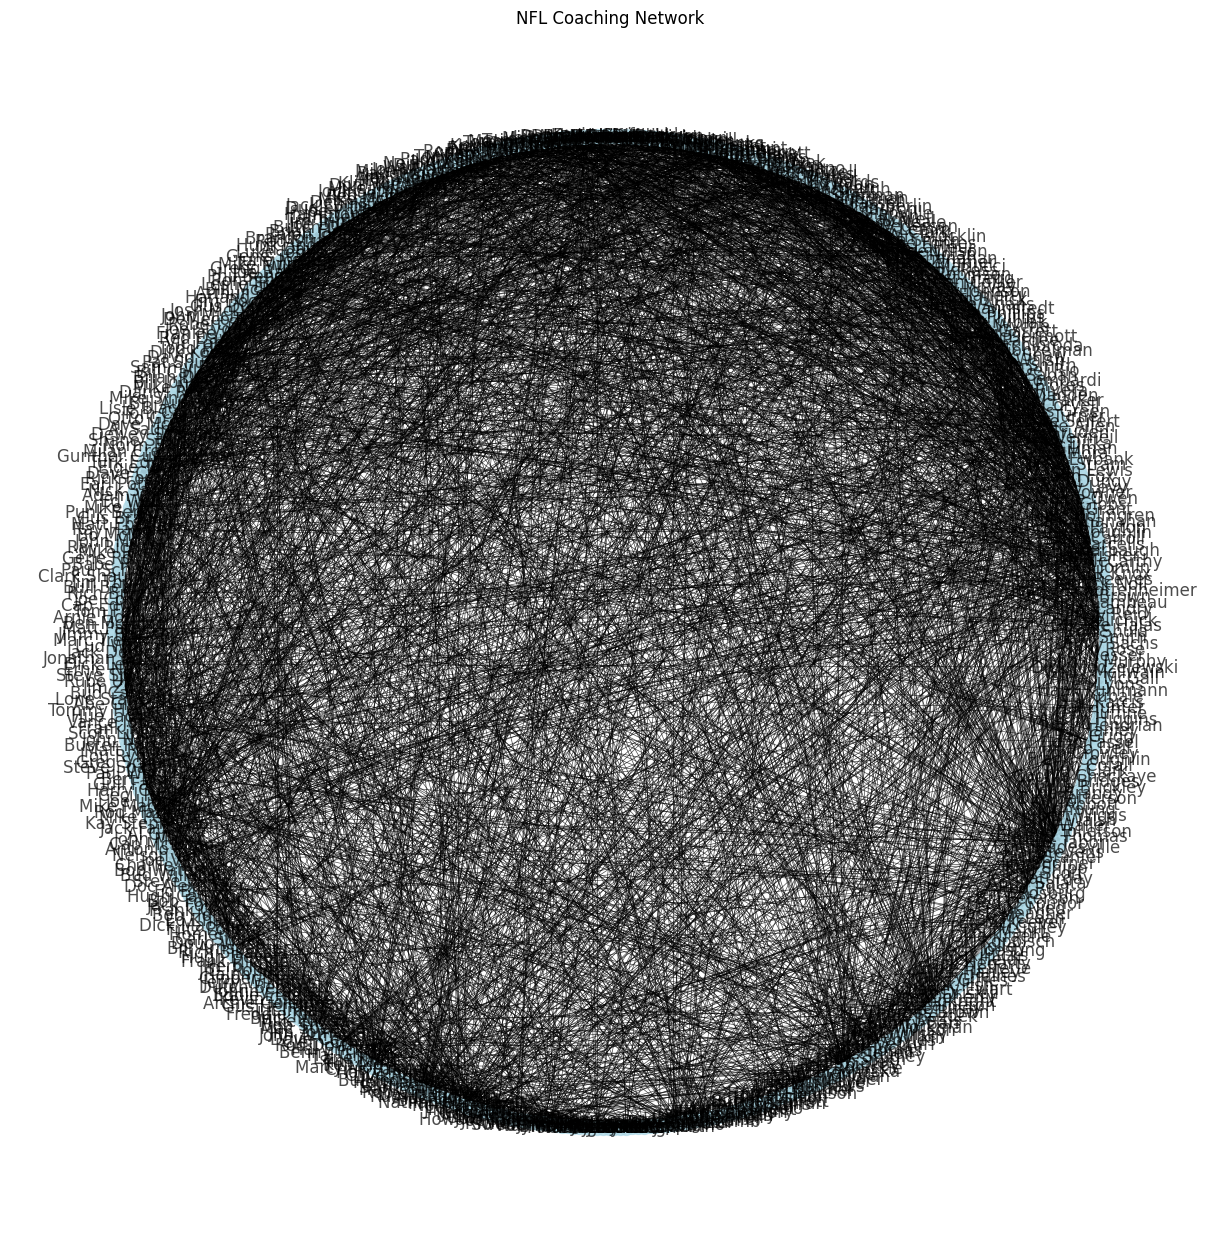

In [14]:
G = nx.from_pandas_adjacency(adjacency_matrix)

plt.figure(figsize=(12,12))
pos = nx.circular_layout(G)
nx.draw(G, pos, 
        node_color='lightblue',
        node_size=100,
        width=0.5,
        alpha=0.7,
        with_labels=True)

plt.title("NFL Coaching Network")
plt.show()


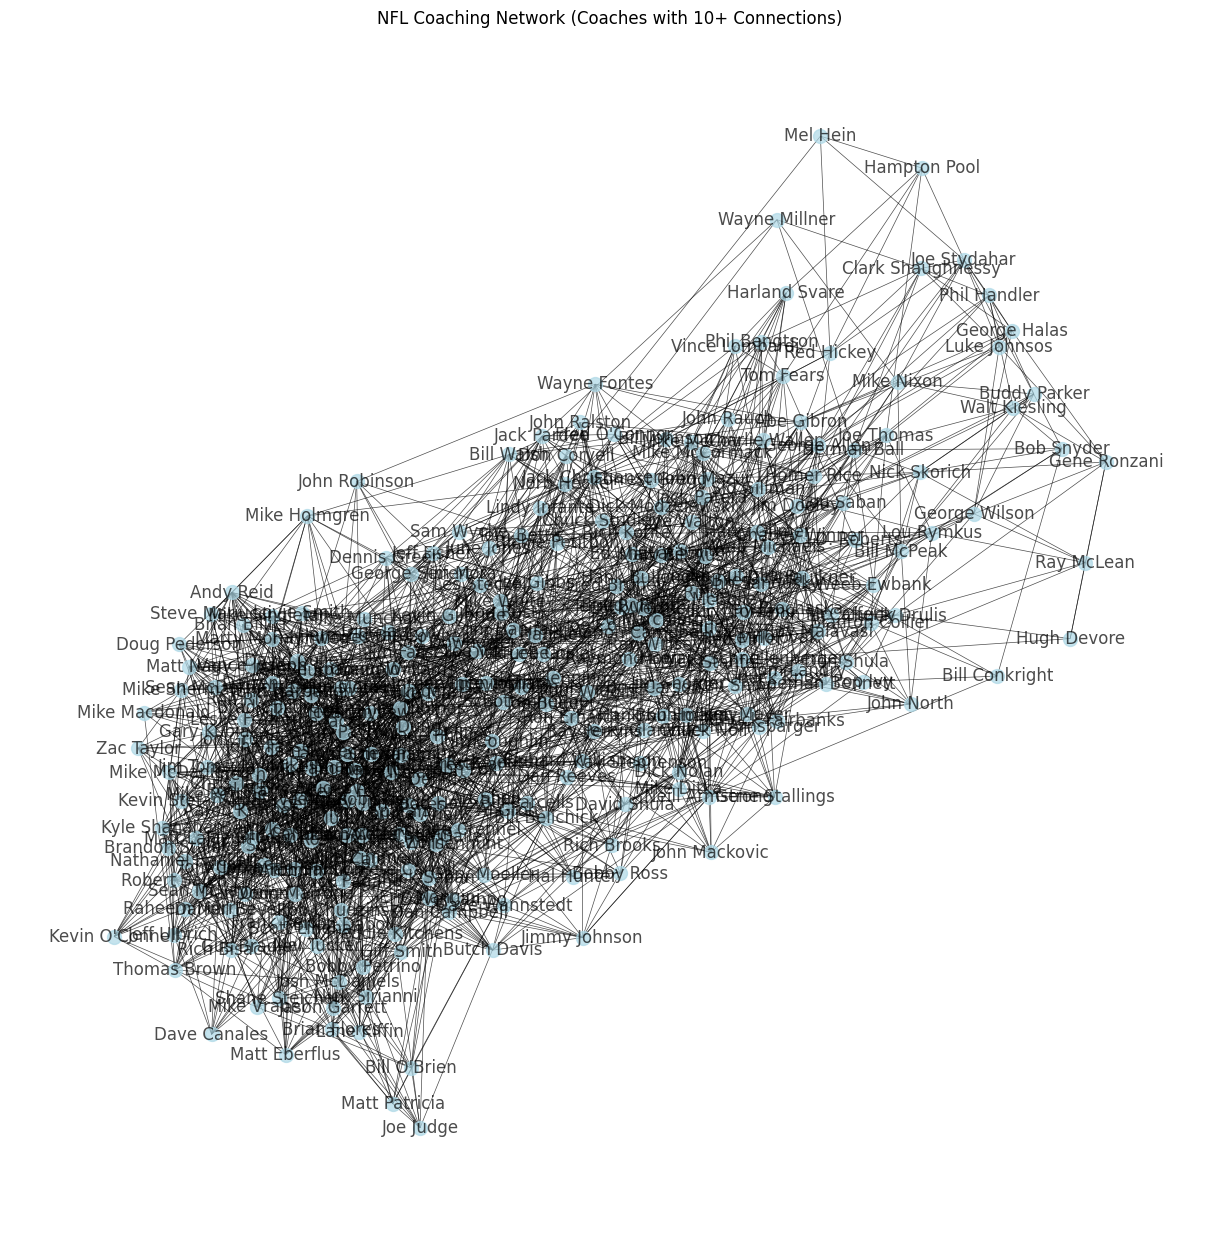

In [9]:
G_connected = G.copy()
n = 10
low_degree = [node for node in G_connected.nodes() if G_connected.degree(node) < n]
G_connected.remove_nodes_from(low_degree)

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G_connected)
nx.draw(G_connected, pos,
        node_color='lightblue',
        node_size=100,
        width=0.5,
        alpha=0.7,
        with_labels=True)

plt.title(f"NFL Coaching Network (Coaches with {n}+ Connections)")
plt.show()
